In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn


In [3]:
from google.colab import files
files.upload()

Saving retail_store_inventory.csv to retail_store_inventory.csv


{'retail_store_inventory.csv': b'Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality\r\n2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.5,20,Rainy,0,29.69,Autumn\r\n2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn\r\n2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer\r\n2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn\r\n2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer\r\n2022-01-01,S001,P0006,Groceries,South,138,128,102,139.82,76.83,10,Sunny,1,79.35,Winter\r\n2022-01-01,S001,P0007,Furniture,East,359,97,167,108.92,34.16,10,Rainy,1,36.55,Winter\r\n2022-01-01,S001,P0008,Clothing,North,380,312,54,329.73,97.99,5,Cloudy,0,100.09,Spring\r\n2022-01-01,S001,P0009,Electronics,West,183,175,135,174.15,20.74,10,Cloudy,0,17.66,Autumn\r\n2

In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("retail_store_inventory.csv")

df['Date'] = pd.to_datetime(df['Date'])

df.head()


Date Store ID Product ID     Category Region  Inventory Level  \
0 2022-01-01     S001      P0001    Groceries  North              231   
1 2022-01-01     S001      P0002         Toys  South              204   
2 2022-01-01     S001      P0003         Toys   West              102   
3 2022-01-01     S001      P0004         Toys  North              469   
4 2022-01-01     S001      P0005  Electronics   East              166   

   Units Sold  Units Ordered  Demand Forecast  Price  Discount  \
0         127             55           135.47  33.50        20   
1         150             66           144.04  63.01        20   
2          65             51            74.02  27.99        10   
3          61            164            62.18  32.72        10   
4          14            135             9.26  73.64         0   

  Weather Condition  Holiday/Promotion  Competitor Pricing Seasonality  
0             Rainy                  0               29.69      Autumn  
1             Sunny                  0               66.16      Autumn  
2             Sunny                  1               31.32      Summer  
3            Cloudy                  1               34.74      Autumn  
4             Sunny                  0               68.95      Summer

 **FEATURE
 ENGINEERING**

In [5]:

df['Total Sales'] = df['Units Sold'] * df['Price']

df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year


**1.DEMAND FORECASTING**

**Demand Forecasting (Time-Series by Product)**

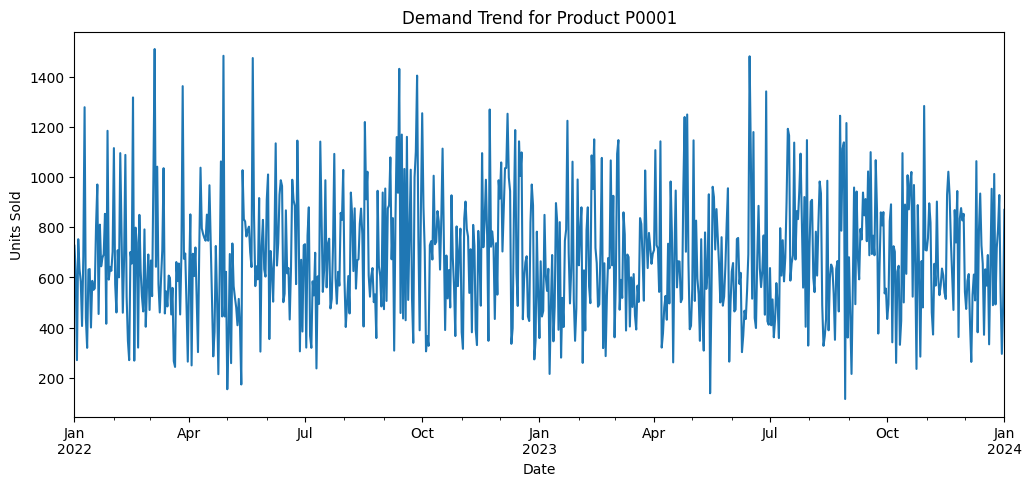

In [6]:

product_ts = df[df['Product ID'] == 'P0001'].groupby('Date')['Units Sold'].sum()

product_ts.plot(figsize=(12,5), title='Demand Trend for Product P0001')
plt.ylabel("Units Sold")
plt.xlabel("Date")
plt.show()


**ARIMA Time Series Forecasting**

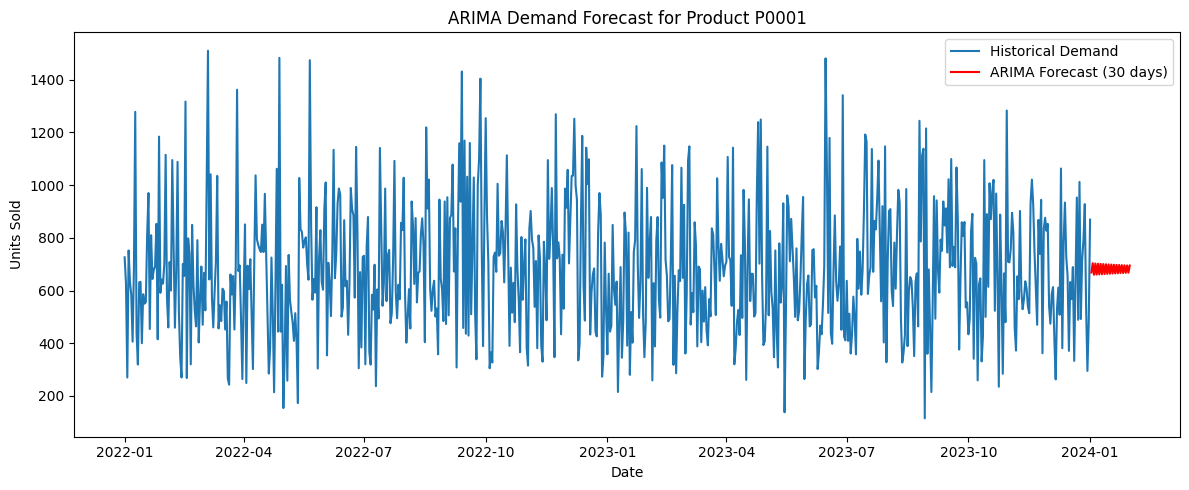

In [37]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

df['Date'] = pd.to_datetime(df['Date'])
product_ts = df[df['Product ID'] == 'P0001'].groupby('Date')['Units Sold'].sum().asfreq('D').fillna(0)

model = ARIMA(product_ts, order=(2,1,2))
fitted_model = model.fit()
forecast = fitted_model.forecast(steps=30)

plt.figure(figsize=(12, 5))
plt.plot(product_ts, label='Historical Demand')
plt.plot(forecast, label='ARIMA Forecast (30 days)', color='red')
plt.title('ARIMA Demand Forecast for Product P0001')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.tight_layout()
plt.show()


**Machine Learning Regression Forecasting (Random Forest)**

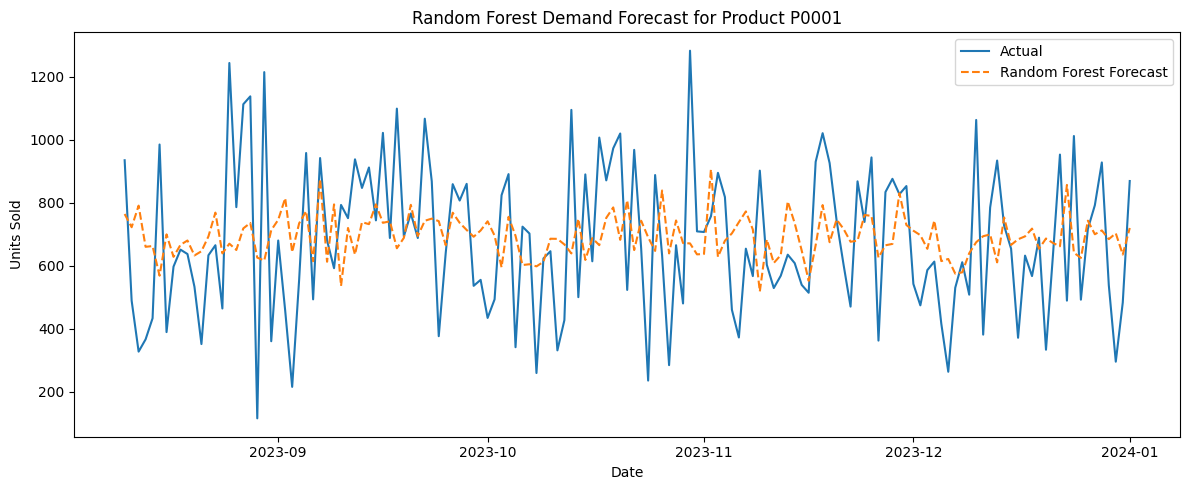

MAE: 198.2846896551724


In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

df_ml = pd.DataFrame({'y': product_ts})
for lag in range(1, 8):
    df_ml[f'lag_{lag}'] = df_ml['y'].shift(lag)

df_ml.dropna(inplace=True)
X = df_ml.drop(columns='y')
y = df_ml['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred, label='Random Forest Forecast', linestyle='--')
plt.title('Random Forest Demand Forecast for Product P0001')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.tight_layout()
plt.show()

print("MAE:", mean_absolute_error(y_test, y_pred))


**2.ABC ANALYSIS**

In [7]:
abc_df = df.groupby('Product ID')['Total Sales'].sum().reset_index()
abc_df = abc_df.sort_values(by='Total Sales', ascending=False)
abc_df['Cumulative %'] = abc_df['Total Sales'].cumsum() / abc_df['Total Sales'].sum()

def classify(cum_pct):
    if cum_pct <= 0.7:
        return 'A'
    elif cum_pct <= 0.9:
        return 'B'
    else:
        return 'C'

abc_df['Class'] = abc_df['Cumulative %'].apply(classify)
abc_df.head()



Product ID  Total Sales  Cumulative % Class
19      P0020  28306192.40      0.051444     A
10      P0011  28155025.56      0.102614     A
15      P0016  28153328.38      0.153781     A
13      P0014  28110375.77      0.204869     A
4       P0005  27916663.02      0.255606     A

**3.ECONOMIC ORDER QUANTITY(EQR) ANALYSIS**

In [8]:
# EOQ Formula: sqrt((2DS)/H)
# D = demand/year, S = ordering cost, H = holding cost per unit/year

S = 50
product_demand = df.groupby('Product ID')['Units Sold'].sum().reset_index()
avg_price = df.groupby('Product ID')['Price'].mean().reset_index()

eoq_df = pd.merge(product_demand, avg_price, on='Product ID')
eoq_df['H'] = eoq_df['Price'] *
eoq_df['EOQ'] = np.sqrt((2 * eoq_df['Units Sold'] * S) / eoq_df['H'])
eoq_df.head()


Product ID  Units Sold      Price         H          EOQ
0      P0001      498061  54.547330  5.454733  3021.722098
1      P0002      487827  55.267726  5.526773  2970.962139
2      P0003      493279  54.885759  5.488576  2997.895398
3      P0004      495501  55.538966  5.553897  2986.918505
4      P0005      503648  55.023590  5.502359  3025.443850

**4.REORDER POINT ANALYSIS**

In [9]:

lead_time_days = 7

daily_demand = df.groupby(['Product ID', 'Date'])['Units Sold'].sum().groupby('Product ID').mean().reset_index()
daily_demand.rename(columns={'Units Sold': 'Avg Daily Demand'}, inplace=True)
daily_demand['Reorder Point'] = daily_demand['Avg Daily Demand'] * lead_time_days
daily_demand.head()


Product ID  Avg Daily Demand  Reorder Point
0      P0001        681.341997    4769.393981
1      P0002        667.341997    4671.393981
2      P0003        674.800274    4723.601915
3      P0004        677.839945    4744.879617
4      P0005        688.984952    4822.894665

**5.LEAD TIME ANALYSIS**

In [10]:

lead_analysis = df.groupby('Product ID').agg({
    'Units Ordered': 'sum',
    'Units Sold': 'sum',
    'Inventory Level': 'mean'
}).reset_index()

lead_analysis['Turnover Rate'] = lead_analysis['Units Sold'] / lead_analysis['Inventory Level']
lead_analysis.head()


Product ID  Units Ordered  Units Sold  Inventory Level  Turnover Rate
0      P0001         407890      498061       272.993981    1824.439493
1      P0002         402077      487827       271.146101    1799.129686
2      P0003         402987      493279       274.932695    1794.180936
3      P0004         394665      495501       271.556498    1824.670018
4      P0005         400964      503648       273.041860    1844.581630

**OTHER ASPECTS**

**Sales Trend by Category/Region**

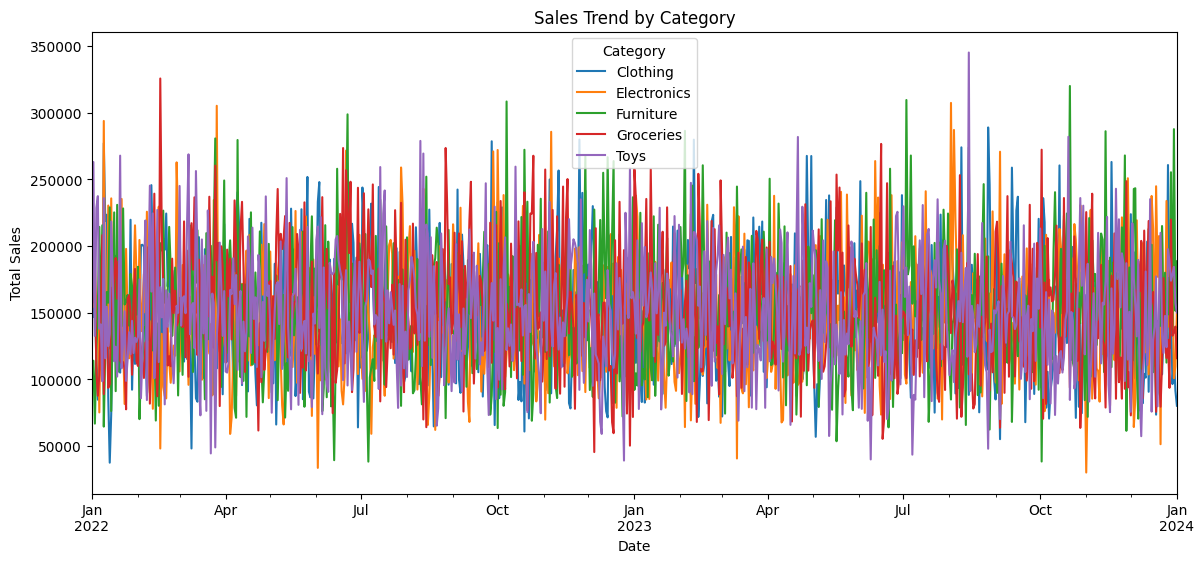

In [11]:
sales_trend = df.groupby(['Date', 'Category'])['Total Sales'].sum().reset_index()
pivot = sales_trend.pivot(index='Date', columns='Category', values='Total Sales')
pivot.plot(figsize=(14,6), title="Sales Trend by Category")
plt.ylabel("Total Sales")
plt.show()


**Monthly Sales Trend**

<Axes: title={'center': 'Monthly Sales Trend'}, xlabel='Month'>

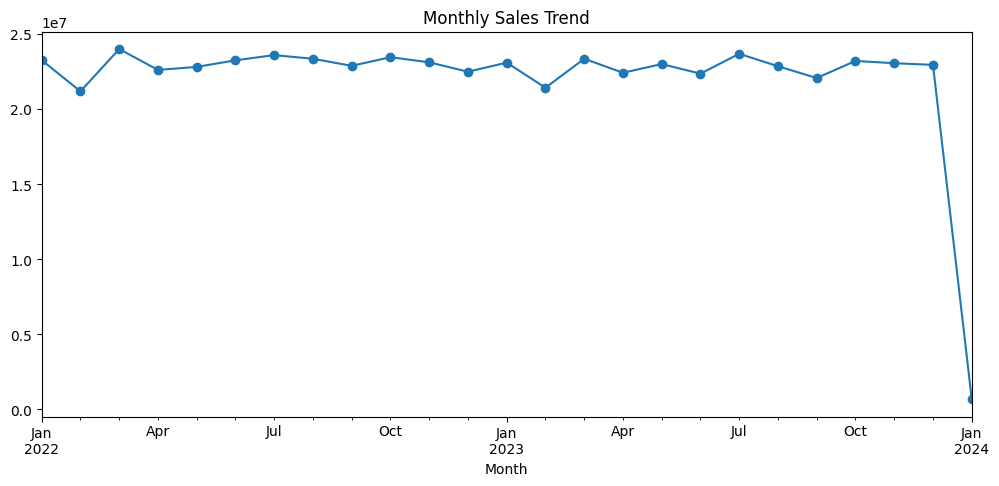

In [43]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.to_period('M')
df['Total Sales'] = df['Units Sold'] * df['Price']

monthly_sales = df.groupby('Month')['Total Sales'].sum()
monthly_sales.plot(marker='o', figsize=(12,5), title='Monthly Sales Trend')


**Supplier Efficiency (Proxy)**

In [15]:
supplier_eff = df.groupby('Product ID')[['Units Sold', 'Units Ordered']].sum()
supplier_eff['Efficiency Ratio'] = supplier_eff['Units Sold'] / supplier_eff['Units Ordered']
print(supplier_eff.sort_values(by='Efficiency Ratio', ascending=False).head())


            Units Sold  Units Ordered  Efficiency Ratio
Product ID                                             
P0015           507283         400720          1.265929
P0014           507622         402485          1.261220
P0016           508472         403376          1.260541
P0009           502086         398726          1.259226
P0005           503648         400964          1.256093


**bold text**

 **Top 10 Products by Total Sales**

<ipython-input-39-b00a536cd905>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")


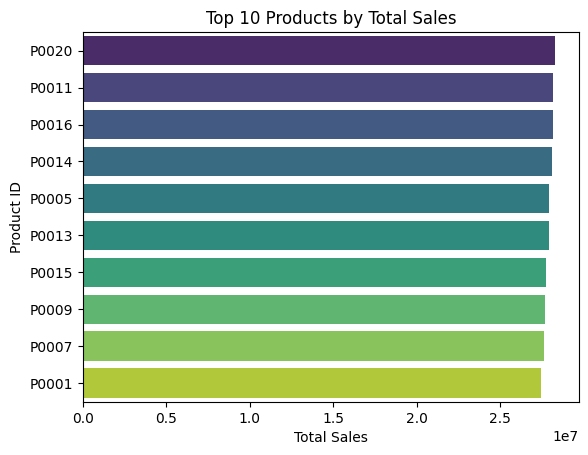

In [39]:
top_products = df.groupby('Product ID')['Total Sales'].sum().sort_values(ascending=False).head(10)

sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")
plt.title("Top 10 Products by Total Sales")
plt.xlabel("Total Sales")
plt.ylabel("Product ID")
plt.show()


**Pie Chart – Category Sales Contribution**

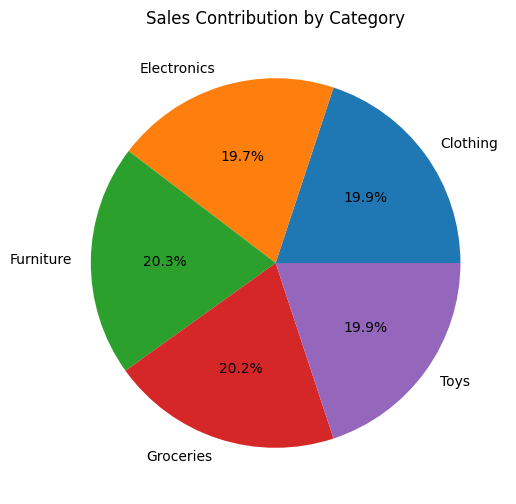

In [40]:
category_sales = df.groupby('Category')['Total Sales'].sum()
category_sales.plot.pie(autopct='%1.1f%%', figsize=(8,6), title="Sales Contribution by Category")
plt.ylabel("")
plt.show()


**Heatmap – Correlation Matrix**

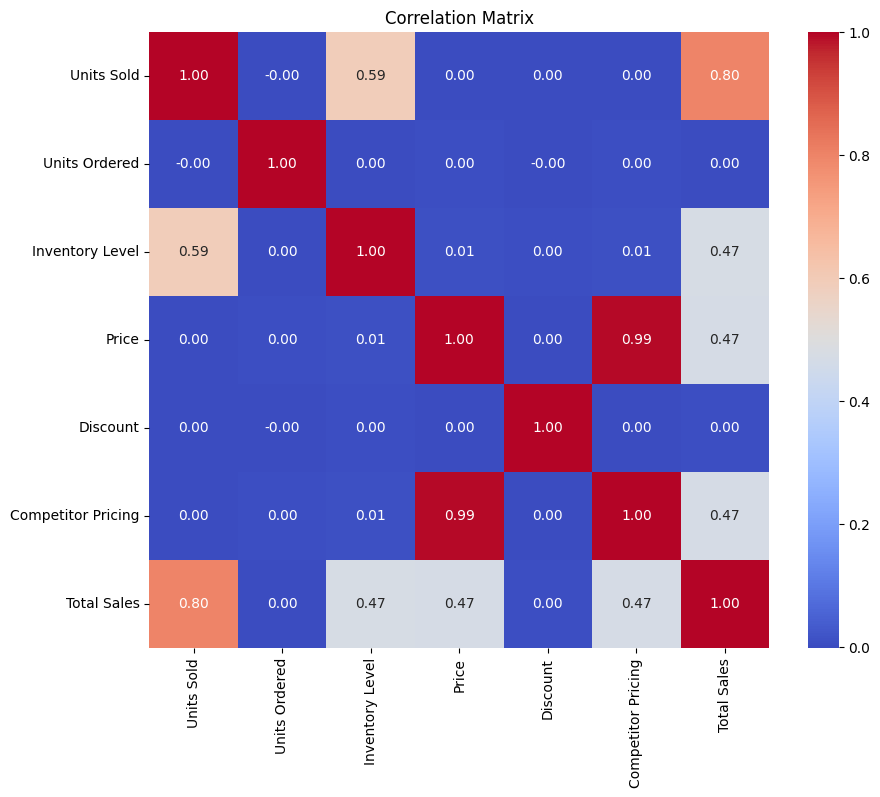

In [41]:
plt.figure(figsize=(10, 8))
corr = df[['Units Sold', 'Units Ordered', 'Inventory Level', 'Price', 'Discount', 'Competitor Pricing', 'Total Sales']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


**Box Plot – Price Distribution by Category**

<ipython-input-24-af23c889e1e9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Price', palette="Set2")


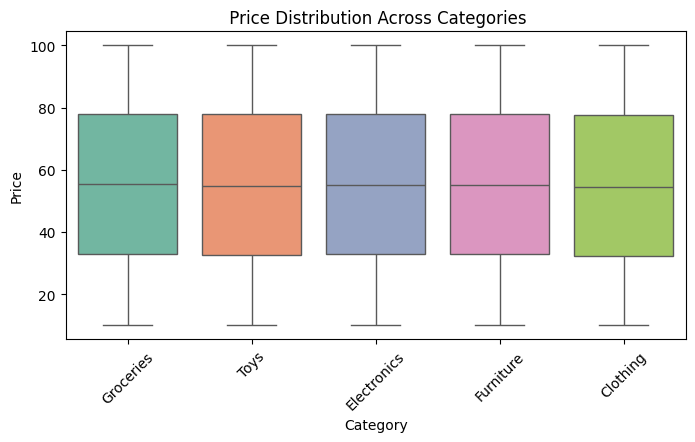

In [24]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x='Category', y='Price', palette="Set2")
plt.title(" Price Distribution Across Categories")
plt.xticks(rotation=45)
plt.show()


**Scatter Plot – Discount vs Units Sold**

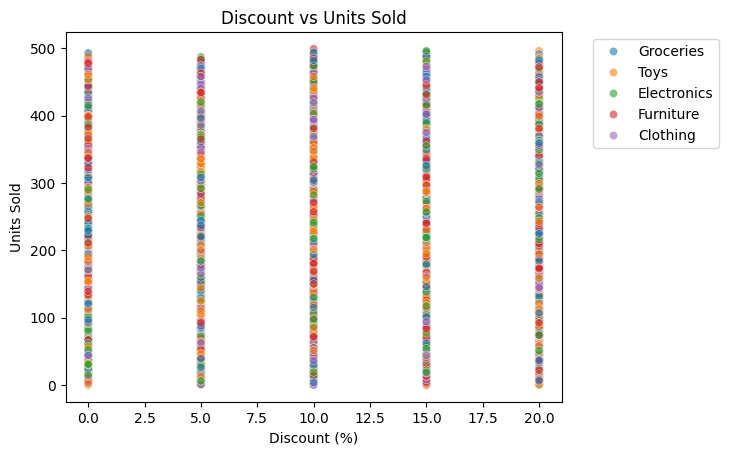

In [42]:
sns.scatterplot(data=df, x='Discount', y='Units Sold', hue='Category', alpha=0.6)
plt.title("Discount vs Units Sold")
plt.xlabel("Discount (%)")
plt.ylabel("Units Sold")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


**Histogram – Inventory Level Distribution**

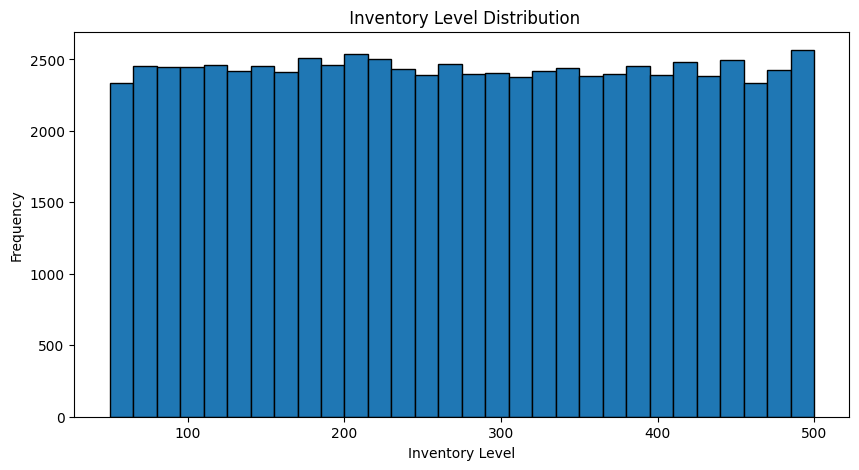

In [27]:
df['Inventory Level'].plot(kind='hist', bins=30, edgecolor='black', figsize=(10,5))
plt.title(" Inventory Level Distribution")
plt.xlabel("Inventory Level")
plt.show()


**Violin Plot – Competitor Pricing by Category**

<ipython-input-29-5f04ba4c5f53>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Category', y='Competitor Pricing', palette='pastel')


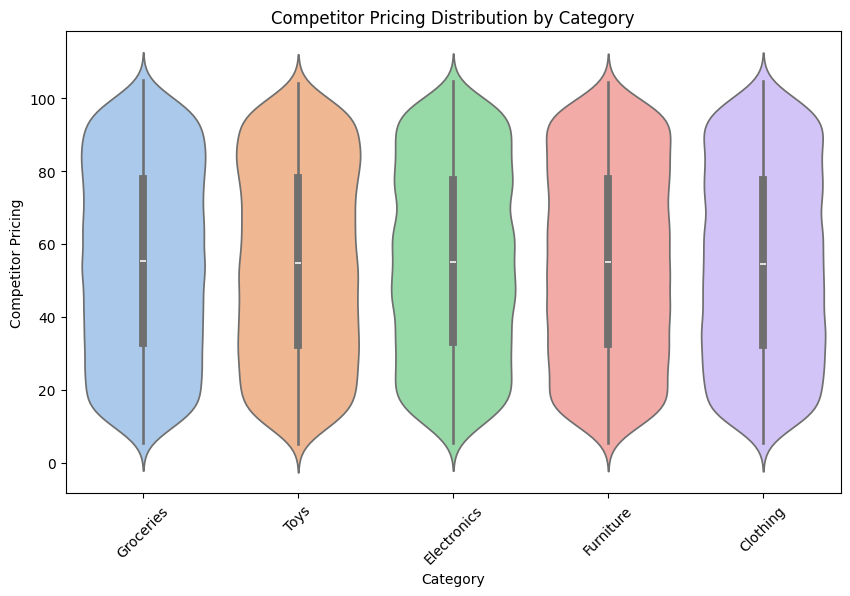

In [29]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='Category', y='Competitor Pricing', palette='pastel')
plt.title("Competitor Pricing Distribution by Category")
plt.xticks(rotation=45)
plt.show()


**Area Plot – Cumulative Sales Over Time**

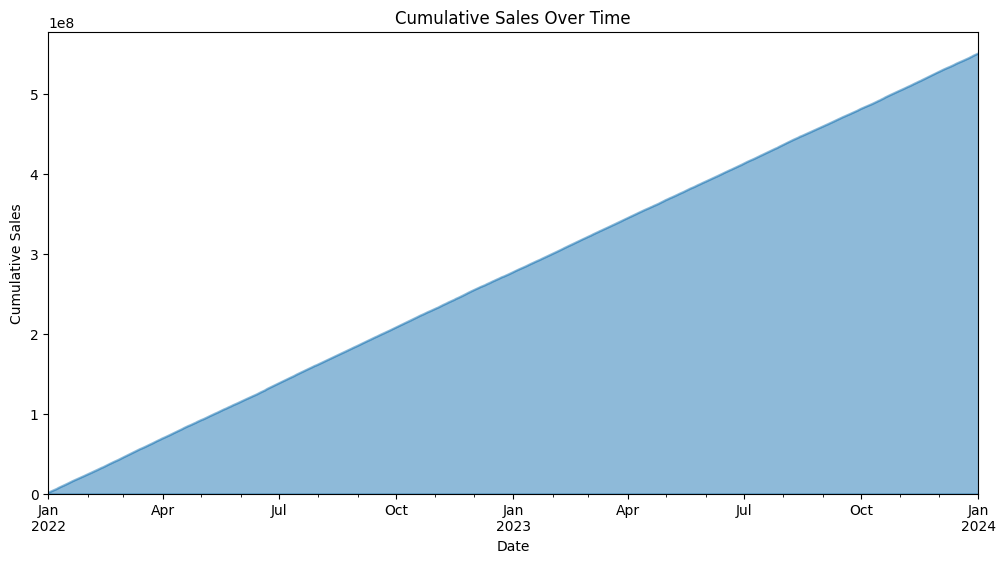

In [31]:
df['Date'] = pd.to_datetime(df['Date'])
sales_time = df.groupby('Date')['Total Sales'].sum().cumsum()

sales_time.plot(kind='area', figsize=(12,6), alpha=0.5, title="Cumulative Sales Over Time")
plt.ylabel("Cumulative Sales")
plt.show()


**COUNT PLOT**

<ipython-input-36-1dec9edac6f0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Category', order=df['Category'].value_counts().index, palette='viridis')


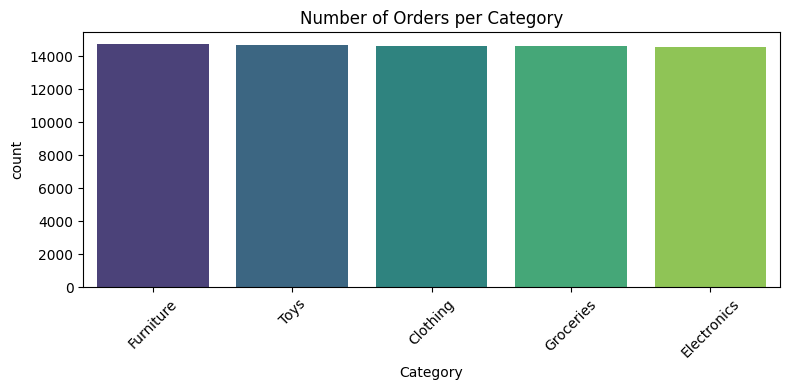

In [36]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='Category', order=df['Category'].value_counts().index, palette='viridis')
plt.title("Number of Orders per Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
